# Research Question: How do economic mobility scores and their subdivisions correlate with key economic indicators such as job value, land value, and the distribution of top-ranking NAICS code categories, and how can Atlanta’s neighborhood divisions be redefined to better reflect current economic realities based on these scores and population data?

## Abstract

Our project focuses on analyzing the index of economic mobility scores. We aim to explore whether economic mobility scores and their finer subdivisions influence other economic factors, such as job value, land value, and the top-ranking NAICS code categories. This research will assess the correlation between economic mobility and these economic indicators.

Additionally, we aim to propose updated divisions for Atlanta neighborhoods. Currently, the neighborhoods are divided into NPUs (Neighborhood Planning Units) and NSAs (Neighborhood Statistical Areas), which were established long ago based on cultural, political, and economic factors. However, these divisions may no longer adequately reflect current economic realities. To address this, we propose redefining the divisions by merging NPUs based on economic mobility scores and total population data.


## Data Preparation and Cleaning 

In [714]:
# import packages
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt
import scipy.stats as stats
import numpy as np
import seaborn as sns
import scipy.stats as stats
import statsmodels.formula.api as smf
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from matplotlib.colors import ListedColormap
from sklearn.linear_model import LinearRegression



In [715]:
# economic mobility dataset
shapefile_path = "/Users/hushiqi/Desktop/ai lab" +\
            "/ONE ATL Mobility Scores by NSA.shp"
mobility_gdf = gpd.read_file(shapefile_path, ignore_geometry=False)
mobility_gdf.head()

,NSA,Economic M,People-bas,Place-base,Economic S,Education,# Total po,# Hispanic,% Hispanic,# Not Hisp,% Not Hisp,geometry
0,A01,63.3,71,61.6,51.9,68.8,4163.4243,94.912699,2.3,18.276663,0.4,"POLYGON ((-84.43968 33.86490, -84.43807 33.863..."
1,A02,64.3,66.7,67.1,56.7,66.8,4287.5654,74.564291,1.7,7.9104476,0.2,"POLYGON ((-84.40845 33.87134, -84.40838 33.871..."
2,A03,62.9,67.8,54.4,56.6,72.8,3199.7598,71.346937,2.2,0,0,"POLYGON ((-84.39663 33.84420, -84.39724 33.844..."
3,B01,63,68.6,59.4,59.5,64.7,4175.3384,146.23899,3.5,0,0,"POLYGON ((-84.39700 33.83840, -84.39700 33.838..."
4,B02,62,65.4,57.2,64.7,60.8,4514.3135,228.93153,5.1,32,0.7,"POLYGON ((-84.38064 33.83962, -84.38087 33.839..."


In [716]:
# business permit data
business_data_path = "/Users/hushiqi/Desktop/ai lab" +\
            "/COA_Permit_Records_2020_032024.xlsx"
business_df = pd.read_excel(business_data_path)
business_df.head()
# what we care is job value from this dataset

,RECORD ID,Address,record type,DATE OPENED,RECORD STATUS,RECORD STATUS DATE,JOB VALUE,JOB VALUE CALCULATED,JOB VALUE CONTRACTOR,DESCRIPTION,Date,Corrected Address,Longitude,Latitude,geometry
0,BB-202000389,"1340 PASADENA AVE NE, ATLANTA, GA 30306",Residential Demolition,1/21/2020,Issued,2020-03-12,20000.0,0.0,20000.0,DEMO SFR F.F.E. 861.17,2020-01-21,"1340 Pasadena Ave NE, Atlanta, Georgia, 30306",-84.343037,33.799383,POINT (33.799383004103 -84.343036992635)
1,BB-202000887,"1123 BENTEEN AVE SE, ATLANTA, GA 30312",Residential Demolition,2/10/2020,Issued,2020-03-02,13000.0,0.0,13000.0,DEMO EXISTING STRUCTURE TO BUILD A NEW SINGLE ...,2020-02-10,"1123 Benteen Ave SE, Atlanta, Georgia, 30312",-84.367517,33.723970,POINT (33.723970015405 -84.367517011411)
2,BB-202001165,"1766 GARRAUX RD NW, ATLANTA, GA 30327",Residential Demolition,2/20/2020,Issued,2020-03-11,20000.0,0.0,20000.0,DEMO OF EXISTING SFR,2020-02-20,"1766 Garraux Rd NW, Atlanta, Georgia, 30327",-84.445359,33.853426,POINT (33.853425995378 -84.44535899183)
3,BB-202001281,"77 BISBEE AVE SE, ATLANTA, GA 30315",Residential Demolition,2/25/2020,Issued,2020-06-24,0.0,0.0,0.0,77 Bisbee Avenue In Rem Demolition,2020-02-25,"77 Bisbee Ave SE, Atlanta, Georgia, 30315",-84.385651,33.716206,POINT (33.716205984222 -84.385651007474)
4,BB-202001286,"2788 BROWNS MILL RD SE, ATLANTA, GA 30354",Residential Demolition,2/25/2020,Issued,2021-01-27,25598.0,0.0,25598.0,962 2788 Browns Mill Road In Rem Demolition,2020-02-25,"2788 Browns Mill Rd SE, Atlanta, Georgia, 30354",-84.383935,33.678676,POINT (33.678676012754 -84.383934980437)


In [717]:
geometry = [Point(xy) for xy in zip(business_df['Longitude'], business_df['Latitude'])]
business_gdf = gpd.GeoDataFrame(business_df, geometry=geometry)

In [718]:
business_mobility_gdf = gpd.sjoin(business_gdf, mobility_gdf, how="left", op='within')

/opt/anaconda3/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3517: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
/var/folders/rp/9x2w7x0j5y75c43279sr0k2m0000gn/T/ipykernel_61279/1118517643.py:1: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:4326

  business_mobility_gdf = gpd.sjoin(business_gdf, mobility_gdf, how="left", op='within')


In [719]:
zero_count = (business_mobility_gdf['JOB VALUE'] == 0).sum()
row_count = business_mobility_gdf.shape[0]
print(zero_count)
print(zero_count/row_count)

380
0.011839112689659469


Permits issued, whether for demolition, land development or other things, typically result in job creation. Additionally, there are instances where the `JOB VALUE CALCULATED`  is non-zero, but `JOB VALUE` is recorded as zero. In such cases, it is reasonable to hypothesize that the zeros in `JOB VALUE` may be errors introduced during the data collection or sampling process. Therefore, observations recorded as zero will be removed from the data. 

In [720]:
business_mobility_gdf = business_mobility_gdf[business_mobility_gdf['JOB VALUE'] != 0]
business_mobility_gdf = business_mobility_gdf.dropna()


In [721]:
parcel = gpd.read_file("/Users/hushiqi/Desktop/ai lab/Publicly_Owned_Parcels_4.shp")
col = ['TOT_APPR', 'NSA', 'NPU', 'geometry']
parcel_filtered = parcel[col]
parcel_filtered_data = parcel_filtered.dropna()
parcel_filtered_data = parcel_filtered_data[parcel_filtered_data['TOT_APPR']!=0]

50% missing data. But we just omit all data with total apprisal value that is equal to 0, since there is complex rules for tax cut and computation for the value. 

Do the log same as the previous reason. 

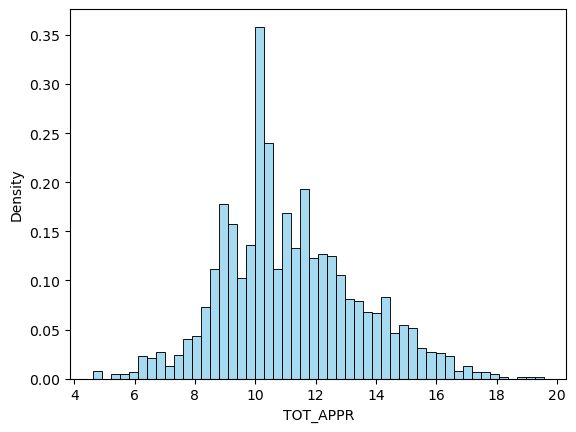

In [722]:
parcel_filtered_data['LOG_TOT_APPR'] = np.log1p(parcel_filtered_data['TOT_APPR'].astype(float))
y = np.log1p(parcel_filtered_data['TOT_APPR'].astype(float))
sns.histplot(y, stat='density', bins=50, color='skyblue', edgecolor='black', label='Histogram')
plt.show()

In [723]:
gpd_f = parcel_filtered_data.merge(mobility_gdf, left_on = 'NSA', right_on = 'NSA')


In [724]:
# Registered Businesses
Registered_Businesses = pd.read_excel("/Users/hushiqi/Desktop/ai lab" +\
            "/Registered_Businesses_2024_Geocoded_Deidentified.xlsx")
Columns_to_keep = ['LICENSE_CLASSIFICATION', 'NAICSCODE_NAME','Disinvested Neighborhood?', 'NPU', 'Council District', 'geometry','Longitude', 'Latitude']

Registered_Businesses_filtered = Registered_Businesses[Columns_to_keep]
Registered_Businesses_filtered = Registered_Businesses_filtered.dropna()


In [725]:
# economic mobility score subdivision
mb_score_full = pd.read_excel("/Users/hushiqi/Desktop/ai lab" +\
            "/economic mobility.xlsx")
mb_score_full[['NPU', 'Column2']] = mb_score_full['NSA_id'].str.extract(r'([A-Za-z]+)(\d+)')
cols = ['NPU', 'Column2'] + [col for col in mb_score_full.columns if col not in ['NPU', 'Column2']]
mb_score_full = mb_score_full[cols]
mb_score_full = mb_score_full.dropna()
mb_score_full.iloc[:, 5:] = mb_score_full.iloc[:, 5:].apply(pd.to_numeric, errors='coerce')
columns_to_group = ['NPU'] + list(mb_score_full.columns[5:])
mb_score_full_npu = mb_score_full[columns_to_group].groupby('NPU').mean().reset_index()


## EDA 

### JOB Value and Economic Mobility Score

In [726]:
business_mobility_gdf['JOB VALUE'] = business_mobility_gdf['JOB VALUE'].astype(float)
data = business_mobility_gdf['JOB VALUE']
skewness = stats.skew(data)
print(skewness) 

40.99159766107546


The skewness is a positive not-near-zero number, which means that that the distribution of `JOB VALUE` is right skewed, with many outliers with high job values as mentioned before. In this case, we log the `JOB VALUE` to make it more visually friendly. 

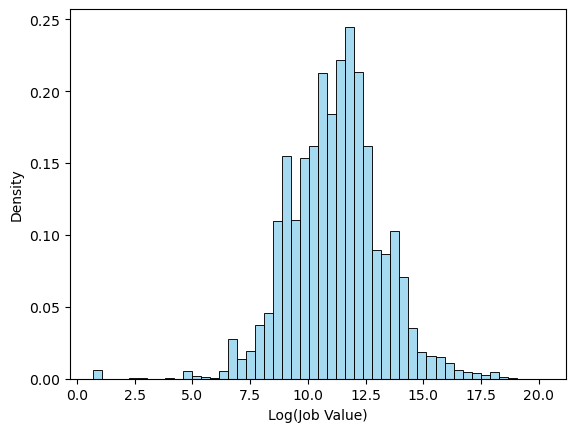

In [727]:
business_mobility_gdf['LOG_JOB_VALUE'] = np.log1p(business_mobility_gdf['JOB VALUE'])  
y = business_mobility_gdf['LOG_JOB_VALUE']
sns.histplot(y, stat='density', bins=50, color='skyblue', edgecolor='black', label='Histogram')
plt.xlabel('Log(Job Value)')
plt.show()


Text(0, 0.5, 'Log Job Value Created')

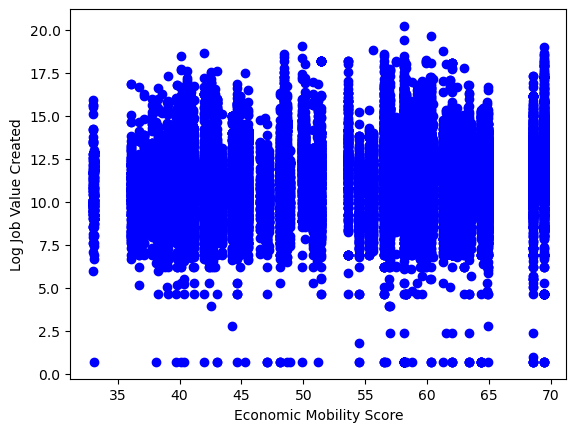

In [728]:
business_mobility_gdf['Economic M'] = business_mobility_gdf['Economic M'].astype(float)
x = business_mobility_gdf['Economic M'].values.reshape(-1, 1) 
y = business_mobility_gdf['LOG_JOB_VALUE'].values
plt.scatter(x, y, color='blue', label='Data Points')
plt.xlabel('Economic Mobility Score')
plt.ylabel('Log Job Value Created')


We can not see clear pattern. 

In [729]:
business_mobility_gdf['Economic_S'] = business_mobility_gdf['Economic S'].astype(float)
business_mobility_gdf['Total_po'] = business_mobility_gdf['# Total po'].astype(float)
business_mobility_gdf['People_bas'] = business_mobility_gdf['People-bas'].astype(float)
business_mobility_gdf['Place_base'] = business_mobility_gdf['Place-base'].astype(float)

model = smf.glm(formula="LOG_JOB_VALUE ~ People_bas + Place_base + Economic_S  + Total_po", data= business_mobility_gdf)
result = model.fit(cov_type='HC0')
summary_table = result.summary().tables[1].as_html()
df_summary = pd.read_html(summary_table, header=0, index_col=0)[0]
significant_variables = df_summary[df_summary['P>|z|'] < 0.05]
print(df_summary)

                coef   std err        z  P>|z|     [0.025     0.975]
Intercept   10.30790  0.075000  136.601    0.0  10.160000  10.456000
People_bas  -0.02270  0.002000  -12.081    0.0  -0.026000  -0.019000
Place_base   0.01140  0.003000    4.250    0.0   0.006000   0.017000
Economic_S   0.03130  0.002000   14.684    0.0   0.027000   0.035000
Total_po    -0.00003  0.000004   -6.824    0.0  -0.000038  -0.000021


/var/folders/rp/9x2w7x0j5y75c43279sr0k2m0000gn/T/ipykernel_61279/2545754669.py:9: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_summary = pd.read_html(summary_table, header=0, index_col=0)[0]


People_base, Place_base, Economic System, and Total_pop are statistically significant. 

In [730]:
business_mobility_gdf_full = business_mobility_gdf.merge(mb_score_full, left_on = 'NSA', right_on = 'NSA_id', how = 'left')
column_name = 'Median_household_income'
column_index = business_mobility_gdf_full.columns.get_loc(column_name)
independent_variables = business_mobility_gdf_full.columns[column_index:]
independent_formula = " + ".join(independent_variables)
formula = f"LOG_JOB_VALUE ~ {independent_formula}"
print(business_mobility_gdf_full.columns)

Index(['RECORD ID', 'Address', 'record type', 'DATE OPENED', 'RECORD STATUS',
       'RECORD STATUS DATE', 'JOB VALUE', 'JOB VALUE CALCULATED',
       'JOB VALUE CONTRACTOR', 'DESCRIPTION', 'Date', 'Corrected Address',
       'Longitude', 'Latitude', 'geometry', 'index_right', 'NSA', 'Economic M',
       'People-bas', 'Place-base', 'Economic S', 'Education ', '# Total po',
       '# Hispanic', '% Hispanic', '# Not Hisp', '% Not Hisp', 'LOG_JOB_VALUE',
       'Economic_S', 'Total_po', 'People_bas', 'Place_base', 'NPU', 'Column2',
       'NSA_id', 'Neighborhood_name', 'council_district',
       'Median_household_income', 'Financially_unstable_families',
       'Access_to_banking_for_people_in_poverty', 'Unemployment',
       'healthy_food_option', 'Housing_cost_burdened_families',
       'Home_ownership', 'Home_ownership1', 'Neighborhood_stability',
       'Violent_crime_rate', 'Vacant_commercial_properties',
       'Community_engagement', 'Neighborhood_engagement', 'Access_to_transit',


In [731]:
model = smf.glm(formula = formula, data= business_mobility_gdf_full)
result = model.fit(cov_type='HC0')
summary_table = result.summary().tables[1].as_html()
df_summary_look = pd.read_html(summary_table, header=0, index_col=0)[0]
significant_variables = df_summary_look[df_summary_look['P>|z|'] < 0.05]
print(significant_variables)

                                       coef       std err       z  P>|z|  \
Intercept                      1.217830e+01  5.250000e-01  23.184  0.000   
Unemployment                   2.090000e-02  5.000000e-03   4.471  0.000   
healthy_food_option           -1.800000e-03  1.000000e-03  -2.614  0.009   
Home_ownership                -2.610000e-02  2.000000e-03 -11.580  0.000   
Home_ownership1                9.000000e-03  3.000000e-03   3.557  0.000   
Neighborhood_stability         1.970000e-02  4.000000e-03   5.261  0.000   
Violent_crime_rate            -6.800000e-03  1.000000e-03 -11.227  0.000   
Neighborhood_engagement        5.600000e-03  1.000000e-03  10.165  0.000   
Access_to_transit             -7.200000e-03  1.000000e-03  -9.072  0.000   
Industries_offering_good_jobs  3.466000e-05  7.710000e-06   4.495  0.000   
Workers_earning_living_wage    2.720000e-02  5.000000e-03   5.094  0.000   
Entrepreneurship               1.750000e-02  2.000000e-03   9.258  0.000   
Small_busine

/var/folders/rp/9x2w7x0j5y75c43279sr0k2m0000gn/T/ipykernel_61279/3025927472.py:4: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_summary_look = pd.read_html(summary_table, header=0, index_col=0)[0]


### Parcel Value and Economic Mobility Score 

In [732]:
gpd_f['LOG_TOT_APPR'] = np.log1p(gpd_f['TOT_APPR'].astype(float))
gpd_f['Economic_S'] = gpd_f['Economic S'].astype(float)
gpd_f['Total_po'] = gpd_f['# Total po'].astype(float)
gpd_f['People_bas'] = gpd_f['People-bas'].astype(float)
gpd_f['Place_base'] = gpd_f['Place-base'].astype(float)
model = smf.glm(formula="LOG_TOT_APPR ~ People_bas + Place_base + Economic_S  + Total_po", data= gpd_f)
result = model.fit(cov_type='HC0')
summary_table = result.summary().tables[1].as_html()
df_summary = pd.read_html(summary_table, header=0, index_col=0)[0]
significant_variables = df_summary[df_summary['P>|z|'] < 0.05]
print(df_summary)

                coef   std err       z  P>|z|    [0.025    0.975]
Intercept   6.634700  0.341000  19.453  0.000  5.966000  7.303000
People_bas -0.013000  0.010000  -1.324  0.186 -0.032000  0.006000
Place_base  0.039800  0.013000   2.955  0.003  0.013000  0.066000
Economic_S  0.067800  0.012000   5.626  0.000  0.044000  0.091000
Total_po   -0.000005  0.000024  -0.224  0.823 -0.000051  0.000041


/var/folders/rp/9x2w7x0j5y75c43279sr0k2m0000gn/T/ipykernel_61279/54134195.py:9: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_summary = pd.read_html(summary_table, header=0, index_col=0)[0]


In [733]:
gpd_f_full = gpd_f.merge(mb_score_full, left_on = 'NSA', right_on = 'NSA_id', how = 'left')
column_name = 'Violent_crime_rate'
column_index = business_mobility_gdf_full.columns.get_loc(column_name)
independent_variables = business_mobility_gdf_full.columns[column_index:]
independent_formula = " + ".join(independent_variables)
formula = f"LOG_TOT_APPR ~ {independent_formula}"
model = smf.glm(formula = formula, data= gpd_f_full)
result = model.fit(cov_type='HC0')
summary_table = result.summary().tables[1].as_html()
df_summary_look = pd.read_html(summary_table, header=0, index_col=0)[0]
significant_variables = df_summary_look[df_summary_look['P>|z|'] < 0.05]
print(significant_variables)

                                   coef   std err      z  P>|z|    [0.025  \
Intercept                      9.948300  1.435000  6.932  0.000  7.135000   
Violent_crime_rate             0.008000  0.002000  3.405  0.001  0.003000   
Access_to_transit             -0.012600  0.003000 -3.820  0.000 -0.019000   
Workers_obtaining_benefits     0.052700  0.016000  3.254  0.001  0.021000   
Access_to_early_learning       0.000092  0.000045  2.046  0.041  0.000004   
Students_on_track_for_college -0.028500  0.008000 -3.754  0.000 -0.043000   

                               0.975]  
Intercept                      12.761  
Violent_crime_rate              0.013  
Access_to_transit              -0.006  
Workers_obtaining_benefits      0.084  
Access_to_early_learning        0.000  
Students_on_track_for_college  -0.014  


/var/folders/rp/9x2w7x0j5y75c43279sr0k2m0000gn/T/ipykernel_61279/357041472.py:10: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_summary_look = pd.read_html(summary_table, header=0, index_col=0)[0]


### Registered Business and Economic Mobility Score

In [734]:
category_counts = Registered_Businesses_filtered['NAICSCODE_NAME'].value_counts()
print(category_counts.head(10))

NAICSCODE_NAME
Full-Service Restaurants                                                 1569
Administrative Management and General Management Consulting Services     1100
Other Business Service Centers (including Copy Shops)                     827
Beauty Salons                                                             636
Offices of Real Estate Agents and Brokers                                 565
Lessors of Residential Buildings and Dwellings                            416
All Other Miscellaneous Store Retailers (except Tobacco Stores)           403
Family Clothing Stores                                                    372
New Single-Family Housing Construction (except For-Sale Builders)         284
Interior Design Services                                                  281
Name: count, dtype: int64


We will study NAICSCODE_NAME with top-two counts, specifically `Full-Service Restaurants` and `Administrative Management and General Management Consulting Services`. 

#### Full-Service Restaurants

In [735]:
filtered_data_naics_res = Registered_Businesses_filtered[Registered_Businesses_filtered['NAICSCODE_NAME'].str.strip() == 'Full-Service Restaurants']
cnt_res = filtered_data_naics_res.groupby('NPU')['NAICSCODE_NAME'].value_counts()
cnt_res = cnt_res.sort_values(ascending=False).reset_index(name='count')
print(cnt_res.head(10))


  NPU             NAICSCODE_NAME  count
0   E  Full-Service Restaurants     375
1   B  Full-Service Restaurants     271
2   M  Full-Service Restaurants     256
3   N  Full-Service Restaurants     120
4   F  Full-Service Restaurants     110
5   D  Full-Service Restaurants      70
6   W  Full-Service Restaurants      70
7   T  Full-Service Restaurants      41
8   R  Full-Service Restaurants      39
9   O  Full-Service Restaurants      32


In [736]:
mobility_gdf[['NPU', 'Column2']] = mobility_gdf['NSA'].str.extract(r'([A-Za-z]+)(\d+)')
mobility_gdf['Economic_M'] = mobility_gdf['Economic M'].astype(float)
mobility_gdf['Economic_S'] = mobility_gdf['Economic S'].astype(float)
mobility_gdf['Total_po'] = mobility_gdf['# Total po'].astype(float)
mobility_gdf['People_bas'] = mobility_gdf['People-bas'].astype(float)
mobility_gdf['Place_base'] = mobility_gdf['Place-base'].astype(float)
mobility_gdf_dd = mobility_gdf.groupby('NPU')[['Economic_M', 'Economic_S', 'Total_po', 'People_bas', 'Place_base']].mean().reset_index()
merge_r = cnt_res.merge(mobility_gdf_dd, on='NPU', how='left')  

model = smf.glm(formula="count ~ People_bas + Place_base + Economic_S  + Total_po", data= merge_r)
result = model.fit(cov_type='HC0')
summary_table = result.summary().tables[1].as_html()
df_summary = pd.read_html(summary_table, header=0, index_col=0)[0]
significant_variables = df_summary[df_summary['P>|z|'] < 0.05]
print(df_summary)

                coef  std err      z  P>|z|   [0.025   0.975]
Intercept  -383.8999  126.881 -3.026  0.002 -632.581 -135.219
People_bas   -3.0942    2.341 -1.322  0.186   -7.682    1.494
Place_base    0.8939    2.285  0.391  0.696   -3.585    5.373
Economic_S   11.2489    5.178  2.172  0.030    1.100   21.398
Total_po      0.0009    0.009  0.099  0.921   -0.017    0.019


/var/folders/rp/9x2w7x0j5y75c43279sr0k2m0000gn/T/ipykernel_61279/2045274320.py:13: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_summary = pd.read_html(summary_table, header=0, index_col=0)[0]


Economic_System 

#### Administrative Management and General Management Consulting Services

In [737]:
filtered_data_naics_ad = Registered_Businesses_filtered[Registered_Businesses_filtered['NAICSCODE_NAME'].str.strip() == 'Administrative Management and General Management Consulting Services']
cnt_ad = filtered_data_naics_ad.groupby('NPU')['NAICSCODE_NAME'].value_counts()
cnt_ad = cnt_ad.sort_values(ascending=False).reset_index(name='count')
print(cnt_ad.head(10))


  NPU                                     NAICSCODE_NAME  count
0   B  Administrative Management and General Manageme...    262
1   E  Administrative Management and General Manageme...    216
2   M  Administrative Management and General Manageme...    162
3   W  Administrative Management and General Manageme...     55
4   F  Administrative Management and General Manageme...     55
5   N  Administrative Management and General Manageme...     43
6   C  Administrative Management and General Manageme...     42
7   A  Administrative Management and General Manageme...     41
8   D  Administrative Management and General Manageme...     35
9   V  Administrative Management and General Manageme...     29


In [738]:
merge_ad = cnt_ad.merge(mobility_gdf_dd, on='NPU', how='left')  
model = smf.glm(formula="count ~ People_bas + Place_base + Economic_S  + Total_po", data= merge_ad)
result = model.fit(cov_type='HC0')
summary_table = result.summary().tables[1].as_html()
df_summary = pd.read_html(summary_table, header=0, index_col=0)[0]
significant_variables = df_summary[df_summary['P>|z|'] < 0.05]
print(df_summary)

                coef  std err      z  P>|z|   [0.025  0.975]
Intercept  -252.4185   95.991 -2.630  0.009 -440.558 -64.279
People_bas   -1.2167    1.406 -0.865  0.387   -3.973   1.540
Place_base   -0.5647    1.793 -0.315  0.753   -4.078   2.949
Economic_S    7.8924    4.357  1.811  0.070   -0.648  16.432
Total_po     -0.0007    0.007 -0.103  0.918   -0.015   0.013


/var/folders/rp/9x2w7x0j5y75c43279sr0k2m0000gn/T/ipykernel_61279/1190587938.py:5: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_summary = pd.read_html(summary_table, header=0, index_col=0)[0]


Economic_System 

### The general picture 

In [739]:
cnt = Registered_Businesses_filtered.groupby('NPU').size().reset_index(name='count')
merge_tot = cnt.merge(mobility_gdf_dd, on='NPU', how='left')  
model = smf.glm(formula="count ~ People_bas + Place_base + Economic_S  + Total_po", data= merge_tot)
result = model.fit(cov_type='HC0')
summary_table = result.summary().tables[1].as_html()
df_summary = pd.read_html(summary_table, header=0, index_col=0)[0]
significant_variables = df_summary[df_summary['P>|z|'] < 0.05]
print(df_summary)

                 coef   std err      z  P>|z|    [0.025   0.975]
Intercept  -2857.0756  1063.573 -2.686  0.007 -4941.640 -772.511
People_bas   -13.6882    18.531 -0.739  0.460   -50.009   22.632
Place_base   -11.6191    22.045 -0.527  0.598   -54.827   31.588
Economic_S    95.8853    51.413  1.865  0.062    -4.883  196.654
Total_po       0.0057     0.087  0.066  0.948    -0.165    0.176


/var/folders/rp/9x2w7x0j5y75c43279sr0k2m0000gn/T/ipykernel_61279/2143643624.py:6: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_summary = pd.read_html(summary_table, header=0, index_col=0)[0]


Economic_System 

In [740]:
merge_tot_subdivisions = merge_tot.merge(mb_score_full_npu, on='NPU', how='left')  
independent_variables = merge_tot_subdivisions.columns[22:28]
independent_formula = " + ".join(independent_variables)
formula = f"count ~ {independent_formula}"
model = smf.glm(formula = formula, data= merge_tot_subdivisions)
result = model.fit(cov_type='HC0')
summary_table = result.summary().tables[1].as_html()
df_summary = pd.read_html(summary_table, header=0, index_col=0)[0]
significant_variables = df_summary[df_summary['P>|z|'] < 0.05]
print(significant_variables)

                     coef  std err      z  P>|z|  [0.025  0.975]
Entrepreneurship  55.4063   17.974  3.083  0.002  20.177  90.636


/var/folders/rp/9x2w7x0j5y75c43279sr0k2m0000gn/T/ipykernel_61279/4053899686.py:8: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_summary = pd.read_html(summary_table, header=0, index_col=0)[0]


Text(0, 0.5, 'Count of Registered Business')

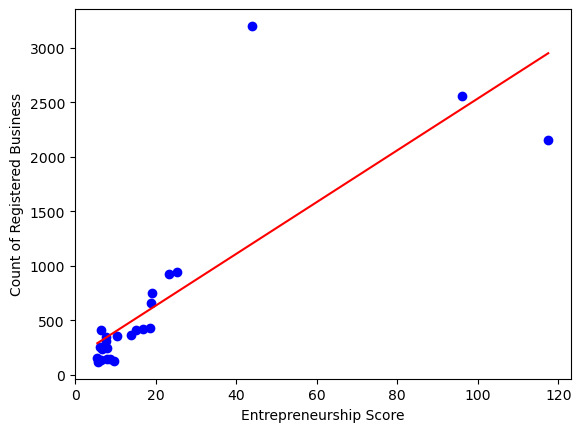

In [749]:
data = merge_tot_subdivisions[['Entrepreneurship', 'count']].dropna()
x = data['Entrepreneurship'].values.reshape(-1, 1) 
y = data['count'].values

regressor = LinearRegression()
regressor.fit(x, y)
x_range = np.linspace(x.min(), x.max(), 500).reshape(-1, 1)
y_pred = regressor.predict(x_range)
plt.plot(x_range, y_pred, color='red', label='Regression Line')
plt.scatter(x, y, color='blue', label='Data Points')
plt.xlabel('Entrepreneurship Score')
plt.ylabel('Count of Registered Business')

Entrepreneurship

#### Clustering 

In [708]:
print(mobility_gdf.columns)

Index(['NSA', 'Economic M', 'People-bas', 'Place-base', 'Economic S',
       'Education ', '# Total po', '# Hispanic', '% Hispanic', '# Not Hisp',
       '% Not Hisp', 'geometry', 'NPU', 'Column2', 'Economic_M', 'Economic_S',
       'Total_po', 'People_bas', 'Place_base'],
      dtype='object')


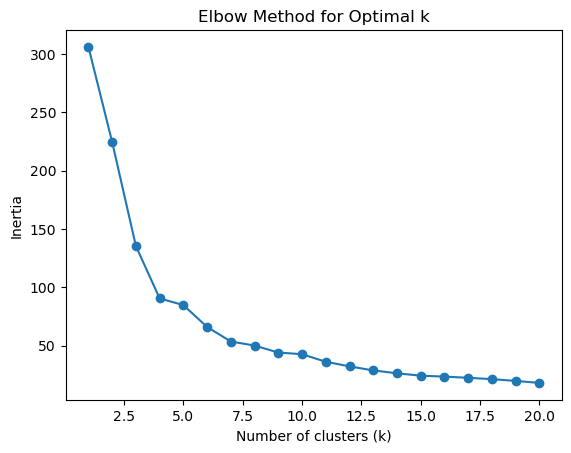

In [709]:
data_to_cluster = mobility_gdf[['Economic_M', 'Total_po', '% Hispanic']]
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data_to_cluster)
inertia = []
for k in range(1, 21):  # Testing k from 1 to 10
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(data_scaled)
    inertia.append(kmeans.inertia_)
plt.plot(range(1, 21), inertia, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.show()


Based on the Elbow Method, the optimal number of cluster is 3 or 4. 

In [710]:
kmeans = KMeans(n_clusters=4, random_state=42)
mobility_gdf['Cluster'] = kmeans.fit_predict(data_scaled)


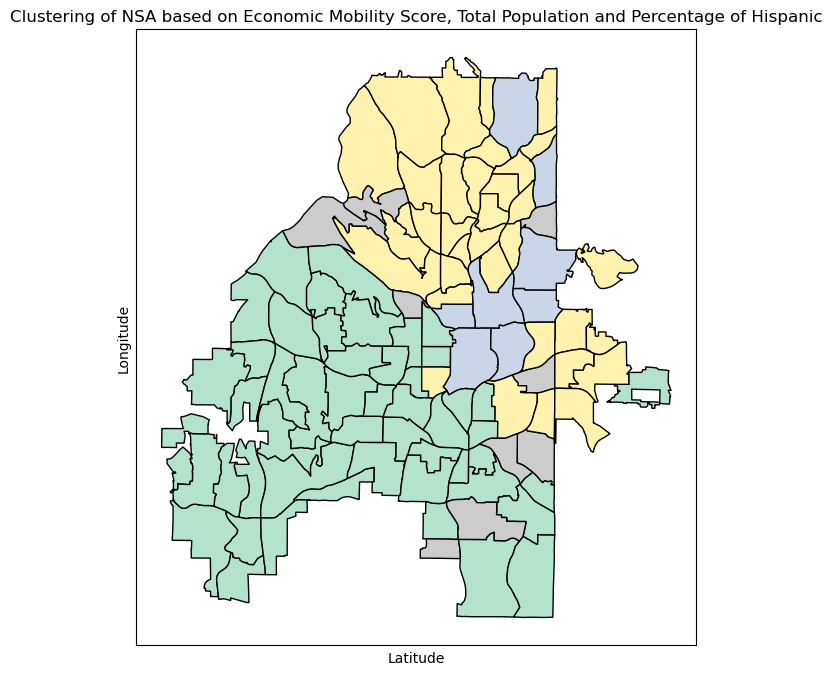

In [711]:
custom_colors = [
    "#e6194b", "#3cb44b", "#ffe119", "#0082c8", "#f58231", "#911eb4",
    "#46f0f0", "#f032e6", "#d2f53c", "#fabebe", "#008080", "#e6beff",
    "#aa6e28", "#800000", "#aaffc3", "#808000", "#ffd8b1", "#000080",
    "#808080", "#ffffff", "#000000", "#bcf60c", "#4363d8", "#dcbeff",
    "#9a6324"
]
custom_cmap = ListedColormap(custom_colors)
mobility_gdf.plot(column='Cluster', cmap='Pastel2', legend=False, figsize=(12, 8), edgecolor = 'black')
plt.title('Clustering of NSA based on Economic Mobility Score, Total Population and Percentage of Hispanic')
plt.xlabel("Latitude")
plt.ylabel("Longitude")
plt.gca().set_xticks([])
plt.gca().set_yticks([])
plt.show()

